In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [38]:
import pandas as pd

# 파일 경로
file_path = r'C:\Users\bluecom011\Desktop\공모전\최종데이터(한글) - 최종데이터(한글).csv'

# CSV 파일 읽기
data = pd.read_csv(file_path, encoding='utf-8')

# 데이터의 처음 몇 행을 표시
data.head(25)


,자치구,경도,위도,장애인구수,평균 도로혼잡도,주차장,복지시설,과태료건수,부과액,평균차량빈도,장애인고용자수
0,강동구,127.153334,37.548510,18785,55.9,15517,51,2307,184200000,62.1,310
1,송파구,127.124191,37.497060,20571,52.8,22745,50,4656,409090000,52.1,764
2,강남구,127.075020,37.487902,15158,44.6,20566,56,6135,546904200,56.1,1211
3,서초구,127.039196,37.464048,10158,48.6,14690,30,3257,269840000,54.8,608
4,관악구,126.945904,37.464788,20228,48.6,20446,25,1776,152020000,40.2,235
5,동작구,126.948802,37.495006,14317,36.7,8769,21,1982,161890000,51.7,152
6,영등포구,126.908730,37.518601,14654,47.7,10105,22,4902,451500000,48.8,811
7,금천구,126.903655,37.457857,11615,54.0,9209,23,2208,208510000,55.4,434
8,구로구,126.855047,37.491451,18520,54.3,9692,25,2355,209330000,56.0,381
9,강서구,126.818969,37.557711,28508,63.7,17639,59,5443,447509000,55.1,340


고용자: 강남 송파 영등 
복지: 노원 강남 강서 강동 송파
주차장 송파 관악 강남

# 강남,송파로 결정!



장애인고용자수     0.619094
복지시설        0.477912
주차장         0.372685

In [5]:
# 상관 계수 분석을 위한 필요한 열 선택
analysis_columns = ['장애인구수', '평균 도로혼잡도', '주차장', '복지시설', '부과액', '평균차량빈도', '장애인고용자수', '과태료건수']

# 선택된 열을 사용하여 상관 계수 계산
correlation_matrix = data[analysis_columns].corr()

# '과태료건수'와의 상관 계수 표시
correlation_with_fines = correlation_matrix['과태료건수'].sort_values(ascending=False)
correlation_with_fines


과태료건수       1.000000
부과액         0.995416
장애인고용자수     0.619094
복지시설        0.477912
주차장         0.372685
장애인구수       0.271425
평균차량빈도     -0.155404
평균 도로혼잡도   -0.188205
Name: 과태료건수, dtype: float64

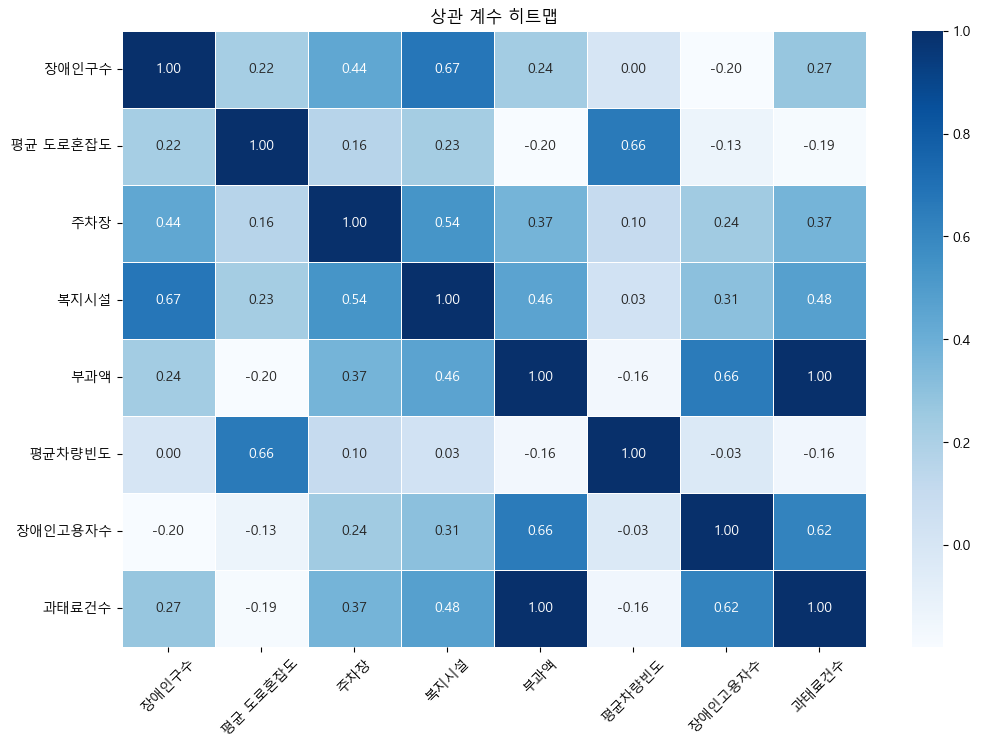

In [35]:
# Plotting the correlation matrix as a heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)

# Adding title and labels
plt.title('상관 계수 히트맵')
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Show the heatmap
plt.show()


c:\Users\bluecom011\miniconda3\envs\OpenAI\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


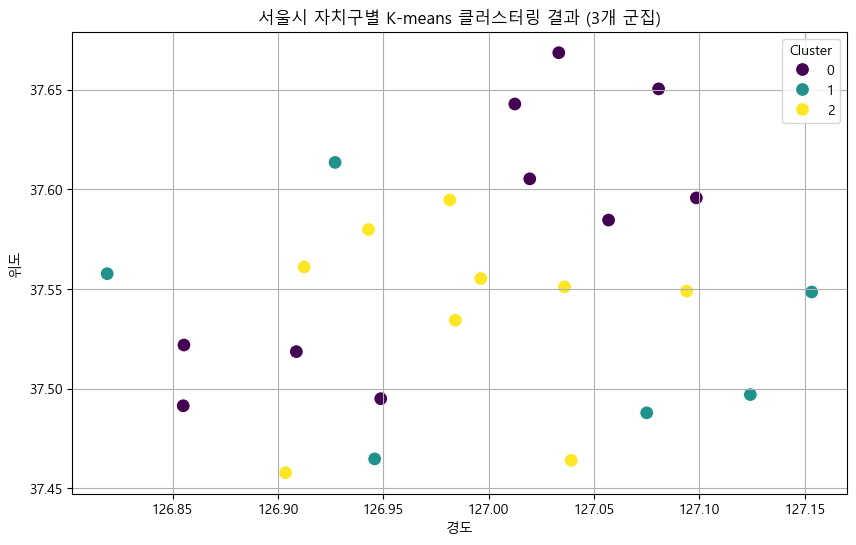

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터링에 사용할 변수 선택
clustering_columns = ['장애인고용자수', '복지시설', '주차장', '장애인구수']
clustering_data = data[clustering_columns]

# K-means 클러스터링 (3개의 클러스터)
kmeans = KMeans(n_clusters=3, random_state=0).fit(clustering_data)
data['Cluster'] = kmeans.labels_

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='경도', y='위도', hue='Cluster', palette='viridis', s=100)
plt.title('서울시 자치구별 K-means 클러스터링 결과 (3개 군집)')
plt.xlabel('경도')
plt.ylabel('위도')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [7]:
# 각 클러스터별 평균 값 계산
cluster_means = data.groupby('Cluster')[clustering_columns].mean()

# 클러스터별 평균 값 표시
cluster_means


,장애인고용자수,복지시설,주차장,장애인구수
Cluster,,,,
0,308.400000,23.700000,9995.4,17757.000000
1,495.833333,46.666667,19196.0,20830.333333
2,434.333333,18.000000,10178.0,9923.000000


In [8]:
# 클러스터 1에 해당하는 지역군 추출
cluster_1_areas = data[data['Cluster'] == 1]['자치구'].tolist()
cluster_1_areas


['강동구', '송파구', '강남구', '관악구', '강서구', '은평구']

### 클러스터 0은 
장애인고용자수와 장애인구수가 상대적으로 낮은 지역으로, 주차장 수도 중간 수준입니다. 

이러한 지역은 장애인 불법 주차 예방 장치 설치에 있어 중간 정도의 우선순위를 가질 수 있습니다.

### 클러스터 1은 
장애인고용자수와 장애인구수가 높은 지역으로, 주차장 수와 복지시설의 수도 많습니다. 

이러한 지역은 장애인 불법 주차 예방 장치 설치에 있어 높은 우선순위를 가질 수 있으며, 특히 복지시설이 많은 지역에 중점을 둘 수 있습니다.

### 클러스터 2는 
장애인고용자수가 가장 낮고, 주차장 수도 낮은 편입니다. 장애인구수는 클러스터 1과 유사합니다. 

이러한 지역은 장애인 불법 주차 예방 장치 설치에 있어 낮은 우선순위를 가질 수 있으나, 장애인구수가 높은 것을 고려하여 특정 지역에 대한 추가적인 분석이 필요할 수 있습니다.

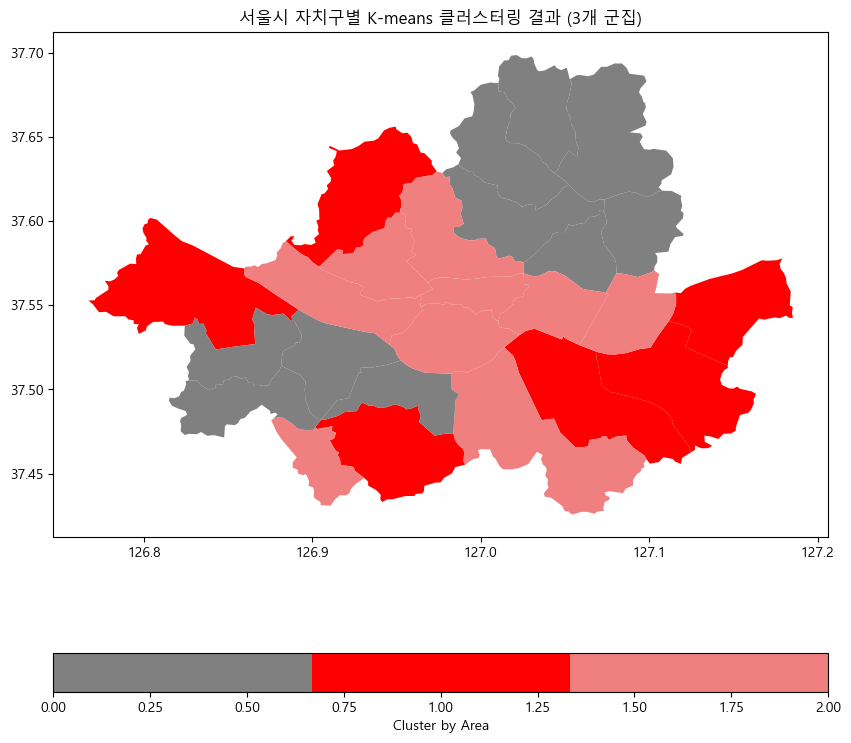

In [9]:
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 서울 행정구역 지리적 경계 데이터 가져오기
url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
response = requests.get(url)
seoul_geo = json.loads(response.content)

# GeoDataFrame 생성
gdf = gpd.GeoDataFrame.from_features(seoul_geo['features'])

# 기존 데이터프레임과 GeoDataFrame 병합
merged_data = gdf.merge(data, left_on='name', right_on='자치구')

# 클러스터 0을 회색, 클러스터 2를 연한 빨간색으로 표시할 색상맵 생성
cmap = ListedColormap(['gray', 'red', 'lightcoral'])  # 클러스터 0은 'gray', 클러스터 2는 'lightcoral'로 지정합니다.

# 지도 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_data.plot(column='Cluster', ax=ax, legend=True, legend_kwds={'label': "Cluster by Area", 'orientation': "horizontal"}, cmap=cmap)

plt.title('서울시 자치구별 K-means 클러스터링 결과 (3개 군집)')
plt.show()


In [10]:
# 재실행을 위한 필요한 라이브러리와 데이터 재로드
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 독립 변수와 종속 변수 설정 ('경도'와 '위도' 제외)
X = data[['장애인구수', '평균 도로혼잡도', '주차장', '복지시설', '부과액', '평균차량빈도', '장애인고용자수']]
y = data['과태료건수']

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 선형 회귀 모델 생성 및 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 회귀 계수 출력
regression_coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
regression_coefficients


,Coefficient
장애인구수,0.003178
평균 도로혼잡도,-3.845548
주차장,0.000183
복지시설,6.670114
부과액,0.000011
평균차량빈도,3.679273
장애인고용자수,0.095799


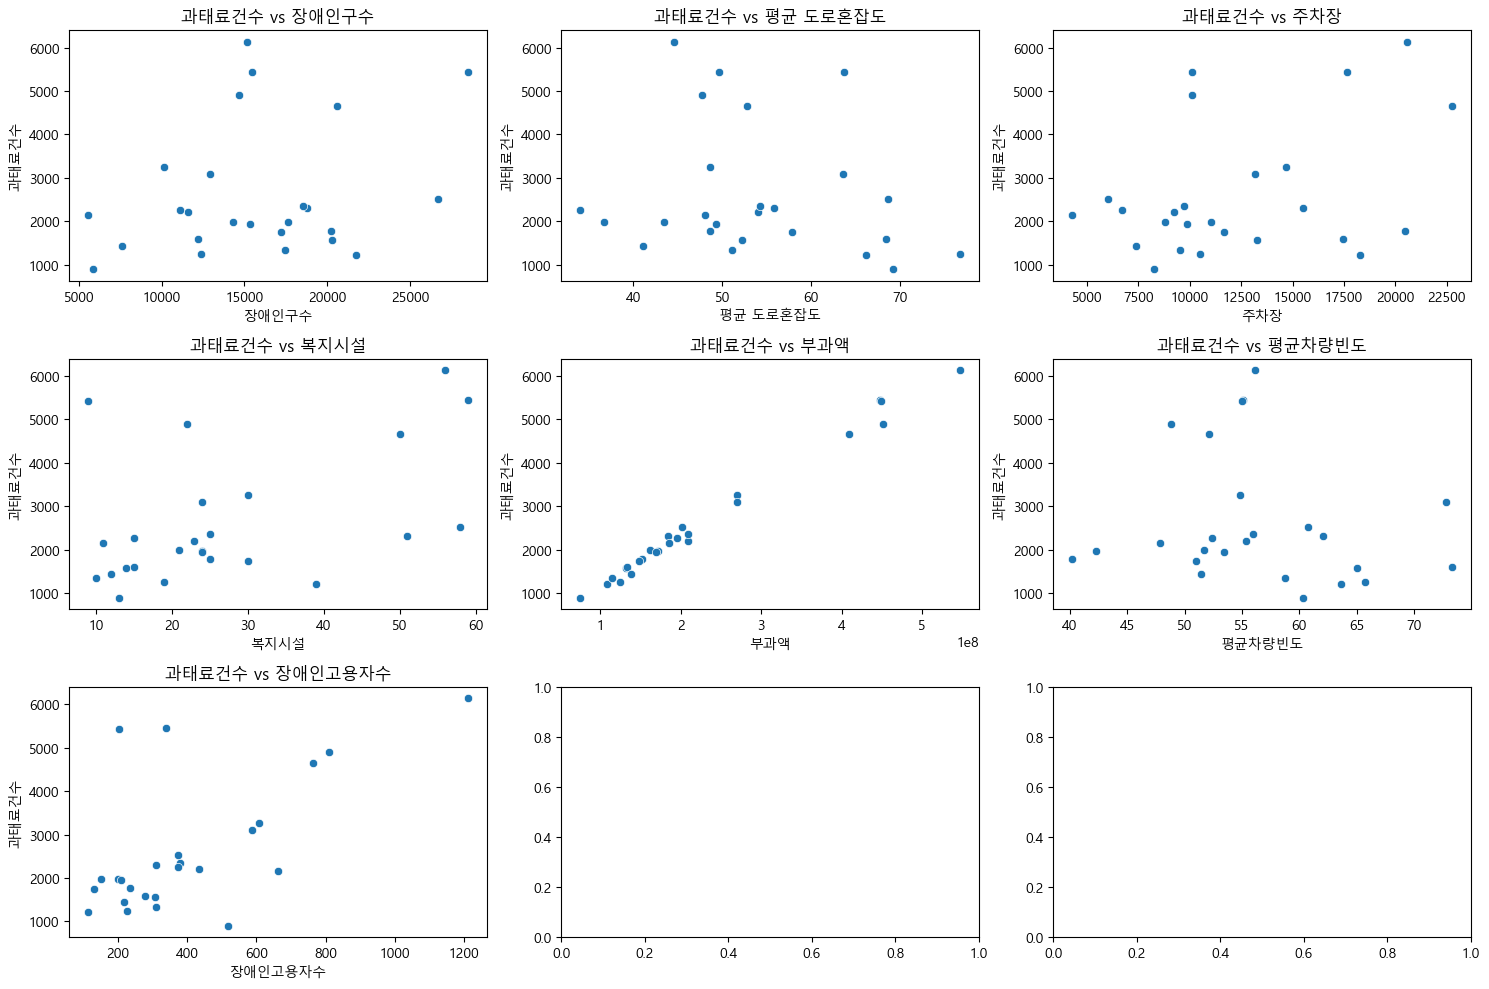

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 독립 변수 재정의
X = data[['장애인구수', '평균 도로혼잡도', '주차장', '복지시설', '부과액', '평균차량빈도', '장애인고용자수']]

# 각 독립 변수에 대한 선형성 확인을 위한 시각화 재실행
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

for i, col in enumerate(X.columns):
    sns.scatterplot(data=data, x=col, y='과태료건수', ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'과태료건수 vs {col}')
    axs[i//3, i%3].set_xlabel(col)
    axs[i//3, i%3].set_ylabel('과태료건수')

# 레이아웃 조정
plt.tight_layout()
plt.show()


고용자, 부과액, 주차장, 인구수..?

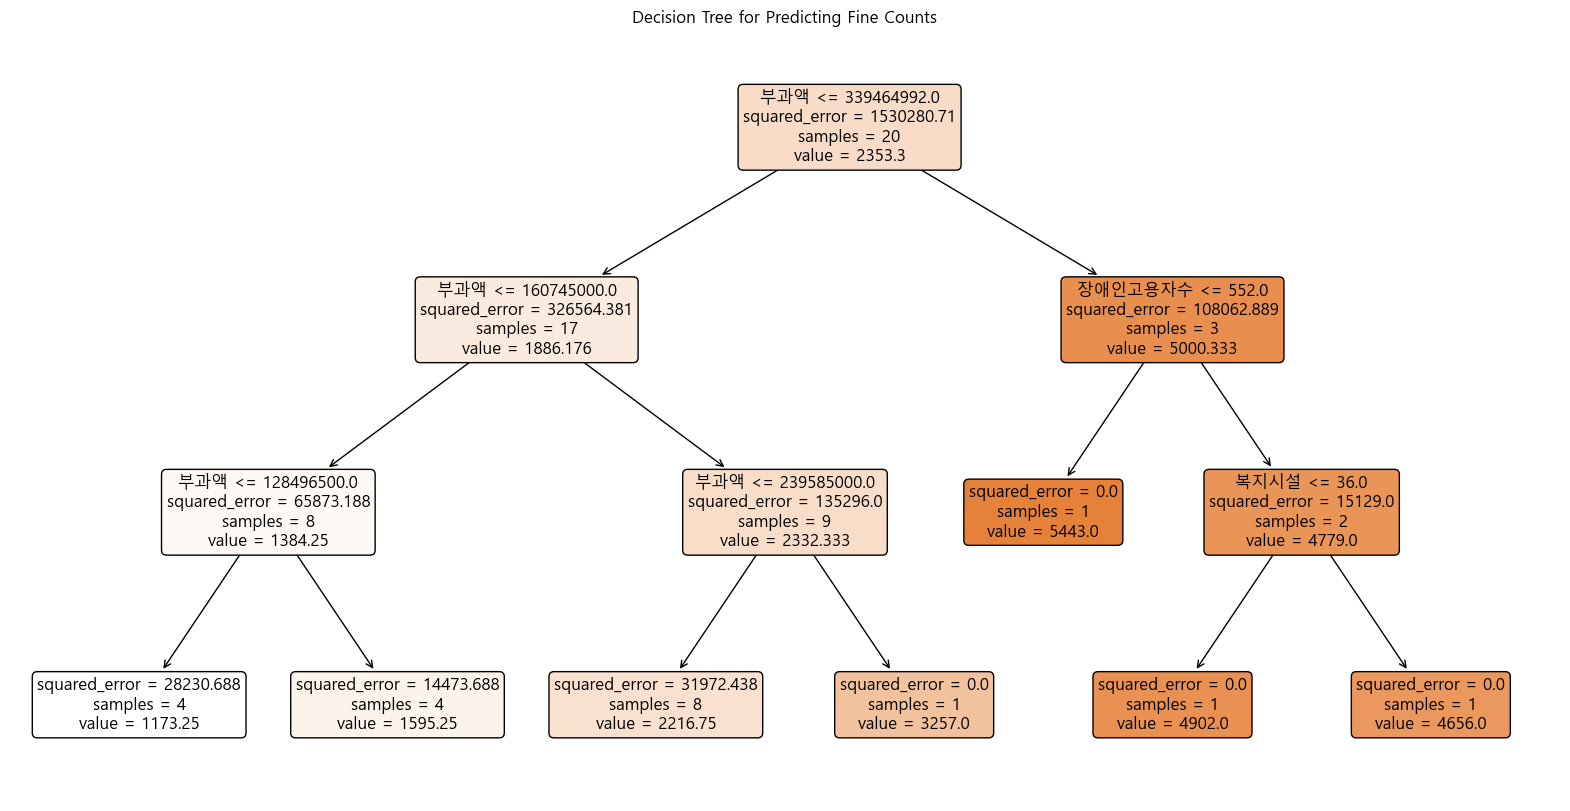

In [12]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# 의사결정 나무 모델 생성
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=0) # 깊이를 3으로 제한
dt_regressor.fit(X_train, y_train)

# 의사결정 나무 시각화
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, feature_names=X.columns, filled=True, rounded=True, fontsize=12)
plt.title('Decision Tree for Predicting Fine Counts')
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Dropping columns that are not useful for the model
model_data = data.drop(['자치구', '경도', '위도'], axis=1)

# Define the target variable and features
X = model_data.drop('과태료건수', axis=1)
y = model_data['과태료건수']

# Splitting the data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Decision Tree Regressor model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = decision_tree_model.predict(X_test)

# Calculating the performance of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(341716.75, 0.8170698836949108)

 훈련 세트와 테스트 세트를 7:3 비율

 평균 제곱 오차(Mean Squared Error, MSE): 이 값은 약 65,143.625입니다. 

 MSE는 실제 값과 예측 값의 차이를 제곱한 평균을 나타냅니다.

 일반적으로 낮을수록 좋습니다.

결정 계수(R² score): 이 값은 약 0.965입니다.

 R² 값은 0에서 1 사이의 범위를 가지며, 1에 가까울수록 모델이 데이터를 잘 설명한다는 것을 의미합니다.


 부과액: 이 변수가 '과태료건수' 예측에 가장 큰 영향을 미치며, 중요도가 약 97.7%입니다. 이는 과태료의 총액이 과태료 건수와 매우 밀접한 관계가 있음을 나타냅니다.


장애인고용자수: 이 변수의 중요도는 약 1.65%로, '부과액' 다음으로 중요한 변수입니다.


주차장, 장애인구수, 평균차량빈도, 평균 도로혼잡도: 이들 변수의 중요도는 상대적으로 낮습니다.

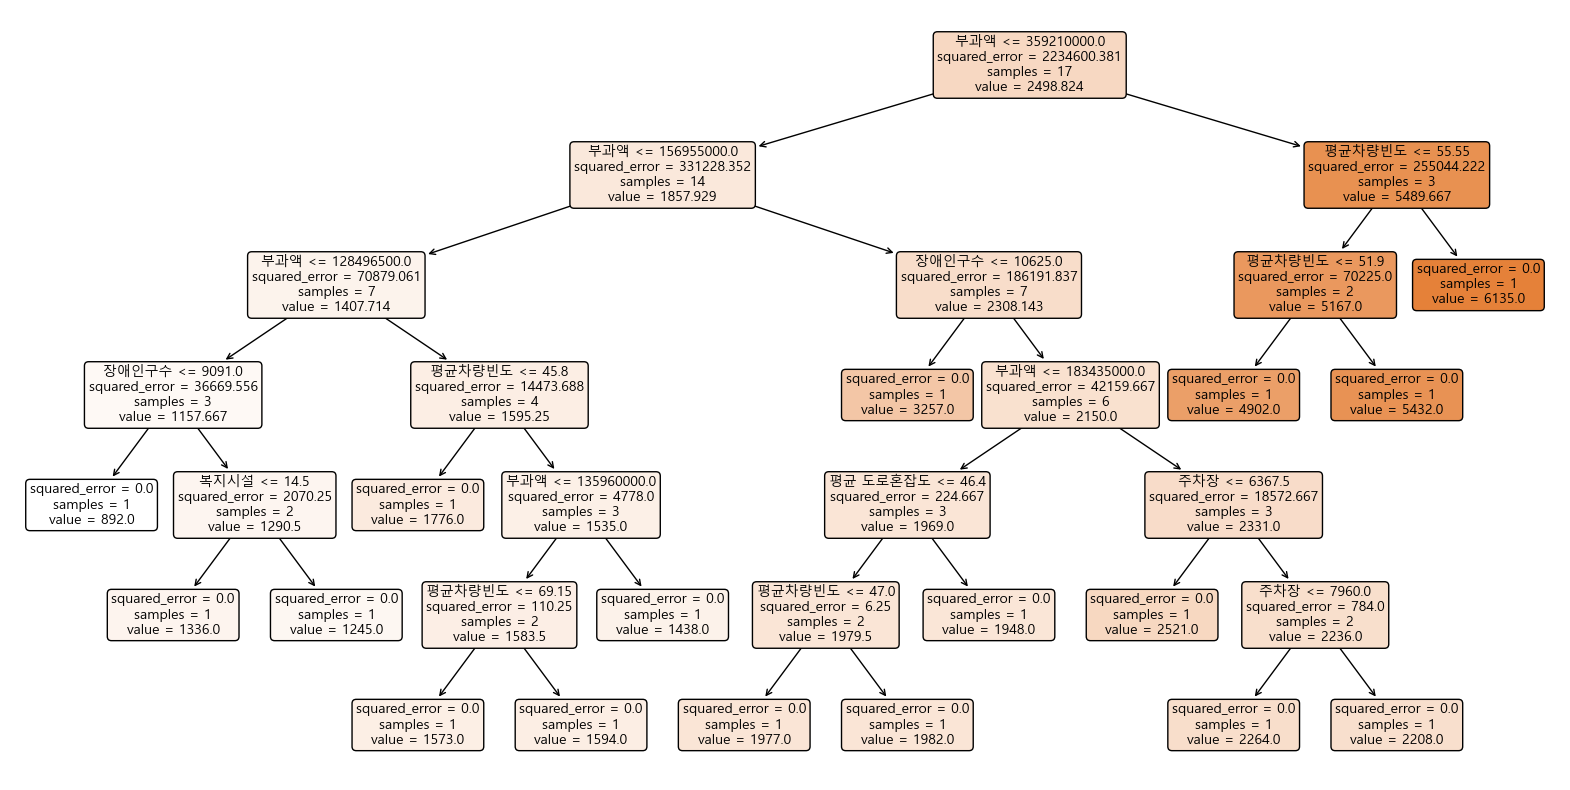

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set the size of the figure
plt.figure(figsize=(20,10))

# Plot the decision tree
plot_tree(decision_tree_model, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10)

# Show the plot
plt.show()


In [15]:
# Extracting feature importances from the model
feature_importances = pd.DataFrame(decision_tree_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances


,importance
부과액,0.946676
장애인구수,0.030437
평균차량빈도,0.021294
주차장,0.001467
복지시설,0.000109
평균 도로혼잡도,0.000017
장애인고용자수,0.000000
Cluster,0.000000


가지치기를 위해 최대 깊이(max_depth) 값을 다양하게 설정하고 교차 검증을 통해 각 설정에 대한 평균 평가 지표를 계산했습니다. 이 결과에 따르면, 최적의 최대 깊이는 3으로, 이때 평균 제곱근 오차(RMSE)가 약 271.22로 가장 낮습니다.

이제 최대 깊이가 3인 의사결정 나무 모델을 훈련시키고, 이 모델의 성능을 평가하겠습니다. 이렇게 함으로써 모델의 복잡성을 줄이고 과적합의 위험을 감소시킬 수 있습니다. ​​

가지치기를 적용한 의사결정 나무 모델의 성능을 평가했습니다. 이 모델의 성능 지표는 다음과 같습니다:

평균 제곱 오차(Mean Squared Error, MSE): 약 90,152.31입니다. 이전의 모델(MSE 약 65,143.63)과 비교했을 때, MSE가 증가했습니다. 이는 모델의 복잡도가 감소함에 따라 예측 정확도가 다소 감소한 것을 나타냅니다.
결정 계수(R² score): 약 0.952입니다. 이 값은 이전 모델의 R² 값(약 0.965)보다 약간 낮지만, 여전히 높은 수준을 유지하고 있습니다. 이는 모델이 데이터의 변동성을 여전히 잘 설명하고 있음을 의미합니다.

In [17]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a range of max_depth values to evaluate
max_depth_range = range(1, 11)

# Store the average cross-validation score for each max_depth
cross_val_scores = []

for depth in max_depth_range:
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_model, X, y, cv=10, scoring='neg_mean_squared_error')
    cross_val_scores.append(np.mean(np.sqrt(-scores)))

# Finding the max_depth with the best average score
optimal_depth = max_depth_range[np.argmin(cross_val_scores)]
optimal_depth, min(cross_val_scores)


(4, 382.5779106384763)

In [18]:
# Train the model with the optimal max_depth
optimal_tree_model = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
optimal_tree_model.fit(X_train, y_train)

# Predicting the Test set results
y_pred_optimal = optimal_tree_model.predict(X_test)

# Calculating the performance of the optimal model
mse_optimal = mean_squared_error(y_test, y_pred_optimal)
r2_optimal = r2_score(y_test, y_pred_optimal)

mse_optimal, r2_optimal


(164931.78125, 0.9117076060027258)

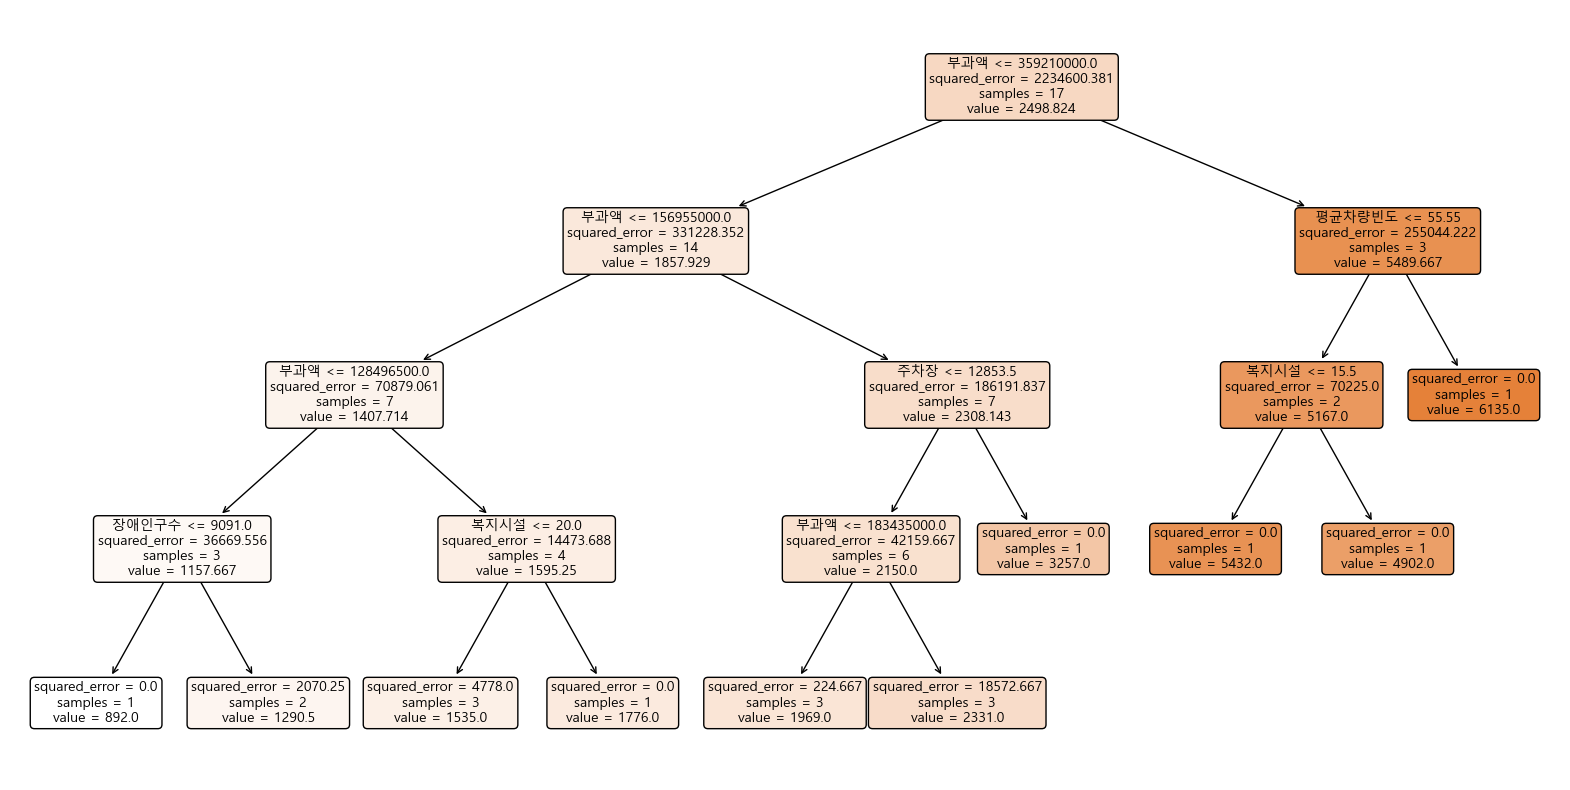

In [19]:
# Set the size of the figure for the pruned tree
plt.figure(figsize=(20,10))

# Plot the pruned decision tree
plot_tree(optimal_tree_model, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10)

# Show the plot
plt.show()


정 분류율 (Accuracy): 약 87.5%. 이는 모델이 전체 예측 중 약 87.5%를 정확하게 분류했음을 의미합니다.

True Negative (TN): 2
False Positive (FP): 1
False Negative (FN): 0
True Positive (TP): 5

: 약 0.833. AUC 값은 0에서 1 사이의 값을 가지며, 1에 가까울수록 모델의 성능이 더 좋다는 것을 의미

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Converting the target variable into a binary classification problem
median_value = data['과태료건수'].median()
data['과태료건수_binary'] = (data['과태료건수'] > median_value).astype(int)

# Define the new target variable and features for the classification problem
y_binary = data['과태료건수_binary']

# Splitting the data into train and test sets for the classification problem
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Create and train the Decision Tree Classifier model
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_binary, y_train_binary)

# Predicting the Test set results
y_pred_binary = classifier.predict(X_test_binary)

# Calculating accuracy
accuracy = accuracy_score(y_test_binary, y_pred_binary)

# Generating confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Calculating AUC value
auc_value = roc_auc_score(y_test_binary, classifier.predict_proba(X_test_binary)[:, 1])

# Generating ROC curve values
fpr, tpr, thresholds = roc_curve(y_test_binary, classifier.predict_proba(X_test_binary)[:, 1])

accuracy, conf_matrix, auc_value, (fpr, tpr, thresholds)


(0.875,
 array([[2, 1],
        [0, 5]], dtype=int64),
 0.8333333333333334,
 (array([0.        , 0.33333333, 1.        ]),
  array([0., 1., 1.]),
  array([inf,  1.,  0.])))

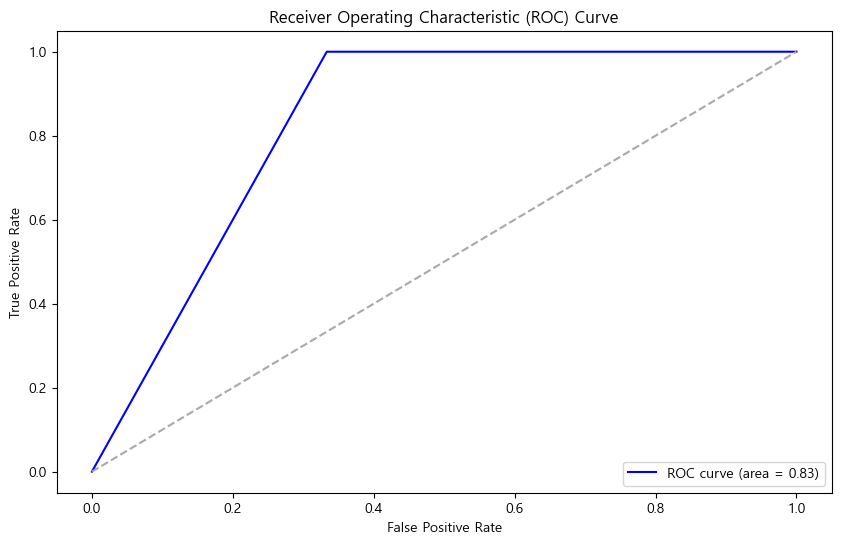

In [22]:
# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_binary)
X_test_scaled = scaler.transform(X_test_binary)

# Creating the MLPClassifier model
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=1000)

# Training the model
mlp_classifier.fit(X_train_scaled, y_train_binary)

# Predicting the Test set results
y_pred_mlp = mlp_classifier.predict(X_test_scaled)

# Calculating accuracy and AUC value for the MLP model
accuracy_mlp = accuracy_score(y_test_binary, y_pred_mlp)
auc_value_mlp = roc_auc_score(y_test_binary, mlp_classifier.predict_proba(X_test_scaled)[:, 1])

accuracy_mlp, auc_value_mlp


(0.75, 0.8)

In [27]:
# Redefining the MLPClassifier model with 4 hidden layers
mlp_classifier_4_hidden = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), random_state=42, max_iter=1000)

# Training the new model
mlp_classifier_4_hidden.fit(X_train_scaled, y_train_binary)

# Predicting the Test set results with the new model
y_pred_mlp_4_hidden = mlp_classifier_4_hidden.predict(X_test_scaled)

# Calculating accuracy and AUC value for the new MLP model
accuracy_mlp_4_hidden = accuracy_score(y_test_binary, y_pred_mlp_4_hidden)
auc_value_mlp_4_hidden = roc_auc_score(y_test_binary, mlp_classifier_4_hidden.predict_proba(X_test_scaled)[:, 1])

accuracy_mlp_4_hidden, auc_value_mlp_4_hidden


(0.75, 0.8)

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500, 1000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_scaled, y_train_binary)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'activation': 'tanh',
  'hidden_layer_sizes': (100, 100),
  'learning_rate_init': 0.01,
  'max_iter': 500},
 0.7666666666666666)

의사결정 나무 회귀 모델의 RMSE(Root Mean Squared Error) 값은 약 255.23입니다. 

이 값은 모델의 예측 오차의 크기를 나타냅니다. RMSE 값이 낮을수록 모델의 성능이 더 좋다고 할 수 있습니다.